In [1]:
from matplotlib import pyplot as plt
from src.datasets.Nii_Gz_Dataset_3D import Dataset_NiiGz_3D
from src.datasets.Nii_Gz_Dataset_3D_customPath import Dataset_NiiGz_3D_customPath
from src.models.Model_M3DNCA import M3DNCA
from src.agents.Agent_M3DNCA_Simple import M3DNCAAgent
from src.losses.LossFunctions import DiceFocalLoss
from src.utils.Study import Study
from src.utils.ProjectConfiguration import ProjectConfiguration
from src.utils.BaselineConfigs import EXP_OctreeNCA3D, EXP_UNet2D, EXP_M3DNCA, EXP_TransUNet, EXP_MEDNCA, EXP_OctreeNCA, EXP_BasicNCA
from src.datasets.png_seg_Dataset import png_seg_Dataset
from src.datasets.Nii_Gz_Dataset import Nii_Gz_Dataset
import octree_vis, os, torch
from src.utils.ProjectConfiguration import ProjectConfiguration
ProjectConfiguration.STUDY_PATH = r"/local/scratch/clmn1/octree_study/"

/home/nlemke/remote/miniconda3/envs/nca/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
study_config = {
        'img_path': r"/local/scratch/jkalkhof/Data/Prostate/Prostate_MEDSeg/imagesTr/",
        'label_path': r"/local/scratch/jkalkhof/Data/Prostate/Prostate_MEDSeg/labelsTr/",
        'name': r'Prostate25',
        'device':"cuda:0",
        'unlock_CPU': True,
        # Optimizer
        'lr_gamma': 0.9999,
        'betas': (0.9, 0.99),
        # Training
        'save_interval': 10,
        'evaluate_interval': 10,
        'n_epoch': 1500,
        # Model
        'input_channels': 1,
        'output_channels': 1,
        'hidden_size': 64,
        'train_model':1,
        'channel_n': 16,
        'kernel_size': [3, 5, 7, 3, 3],
        # Data
        'input_size': [(320, 320, 24)], # (320, 320, 24) -> (160, 160, 12) -> (80, 80, 12) -> (40, 40, 12) -> (20, 20, 12)
        
        'data_split': [1.0, 0, 0.0], 
        'keep_original_scale': False,
        'rescale': True,
        # Octree - specific
        'octree_res_and_steps': [((320,320,24), 40), ((160,160,12), 0), ((80,80,6), 20), ((40,40,6), 0), ((20,20,6), 0)],
        'separate_models': True,
        # (160, 160, 12) <- (160, 160, 12) <- (80, 80, 12) <- (40, 40, 12) <- (20, 20, 12)
        'patch_sizes':[((160, 160, 24)), None, None, None, None],
        #'patch_sizes': [None] *5,
        ### TEMP
        

        'compile': False,
        'batch_size': 4,
        'batch_duplication': 2,
    }
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
torch.autograd.set_detect_anomaly(True)
study = Study(study_config)
dataset = Dataset_NiiGz_3D()
exp = EXP_OctreeNCA3D().createExperiment(study_config, detail_config={}, dataset=dataset)
study.add_experiment(exp)

hyp99_test = Dataset_NiiGz_3D_customPath(resize=True, size=(320, 320, 24), imagePath=r"/local/scratch/jkalkhof/Data/Prostate/Prostate_MEDSeg/imagesTs", labelPath=r"/local/scratch/jkalkhof/Data/Prostate/Prostate_MEDSeg/labelsTs")
hyp99_test.exp = exp
study.my_custom_evaluation_set = hyp99_test
def evaluate():
    print("RUNNING CUSTOM EVALUATION")

    exp.agent.getAverageDiceScore(pseudo_ensemble=True, dataset=study.my_custom_evaluation_set)

study.eval_experiments = evaluate

DATA INSTANCE CREATED
CONFIG {'description': 'OctreeNCA3D', 'lr': 0.0016, 'batch_duplication': 2, 'channel_n': 16, 'inference_steps': 64, 'cell_fire_rate': 0.5, 'batch_size': 4, 'hidden_size': 64, 'train_model': 1, 'betas': (0.9, 0.99), 'kernel_size': [3, 5, 7, 3, 3], 'scale_factor': 4, 'levels': 2, 'input_size': [(320, 320, 24)], 'img_path': '/local/scratch/jkalkhof/Data/Prostate/Prostate_MEDSeg/imagesTr/', 'label_path': '/local/scratch/jkalkhof/Data/Prostate/Prostate_MEDSeg/labelsTr/', 'name': 'Prostate25', 'device': 'cuda:0', 'unlock_CPU': True, 'lr_gamma': 0.9999, 'save_interval': 10, 'evaluate_interval': 10, 'n_epoch': 1500, 'input_channels': 1, 'output_channels': 1, 'data_split': [1.0, 0, 0.0], 'keep_original_scale': False, 'rescale': True, 'octree_res_and_steps': [((320, 320, 24), 40), ((160, 160, 12), 0), ((80, 80, 6), 20), ((40, 40, 6), 0), ((20, 20, 6), 0)], 'separate_models': True, 'patch_sizes': [(80, 80, 24), None, None, None, None], 'compile': False}
/local/scratch/clmn1/

In [3]:
exp.agent.model.state_dict().keys()

odict_keys(['backbone_ncas.0.fc0.weight', 'backbone_ncas.0.fc0.bias', 'backbone_ncas.0.fc1.weight', 'backbone_ncas.0.p0.weight', 'backbone_ncas.0.p0.bias', 'backbone_ncas.0.bn.weight', 'backbone_ncas.0.bn.bias', 'backbone_ncas.1.fc0.weight', 'backbone_ncas.1.fc0.bias', 'backbone_ncas.1.fc1.weight', 'backbone_ncas.1.p0.weight', 'backbone_ncas.1.p0.bias', 'backbone_ncas.1.bn.weight', 'backbone_ncas.1.bn.bias', 'backbone_ncas.2.fc0.weight', 'backbone_ncas.2.fc0.bias', 'backbone_ncas.2.fc1.weight', 'backbone_ncas.2.p0.weight', 'backbone_ncas.2.p0.bias', 'backbone_ncas.2.bn.weight', 'backbone_ncas.2.bn.bias', 'backbone_ncas.3.fc0.weight', 'backbone_ncas.3.fc0.bias', 'backbone_ncas.3.fc1.weight', 'backbone_ncas.3.p0.weight', 'backbone_ncas.3.p0.bias', 'backbone_ncas.3.bn.weight', 'backbone_ncas.3.bn.bias', 'backbone_ncas.4.fc0.weight', 'backbone_ncas.4.fc0.bias', 'backbone_ncas.4.fc1.weight', 'backbone_ncas.4.p0.weight', 'backbone_ncas.4.p0.bias', 'backbone_ncas.4.bn.weight', 'backbone_ncas.

In [4]:
weights = torch.load('/local/scratch/clmn1/octree_study/Experiments/MIA_prostate_M3D_NCA_Run3_None/models/epoch_1500/model.pth')

backbone2_weights = {}
backbone0_weights = {}

keys = list(weights.keys())
for key in keys:
    if key.startswith('model.1'):
        new_key = key.replace('model.1.', '')
        backbone0_weights[new_key] = weights.pop(key)
    elif key.startswith('model.0'):
        new_key = key.replace('model.0.', '')
        backbone2_weights[new_key] = weights.pop(key)

In [5]:
exp.agent.model.backbone_ncas[0].load_state_dict(backbone0_weights)
exp.agent.model.backbone_ncas[2].load_state_dict(backbone2_weights)

<All keys matched successfully>

Epoch: 1
Dataset size: 7


  0%|          | 0/7 [00:00<?, ?it/s]

[[ 0  0  0]
 [20 20  6]]


/gris/gris-f/homestud/nlemke/NCA/src/models/Model_OctreeNCA_3d_patching2.py:99: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at ../c10/core/TensorImpl.h:1908.)
  x.names = ('B', 'H', 'W', 'D', 'C')


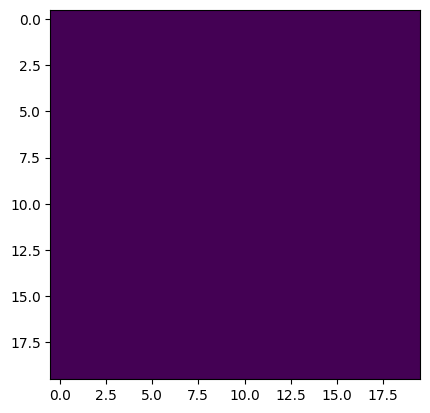

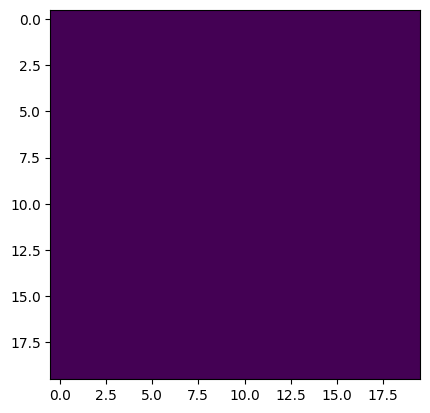

[[ 0  0  0]
 [40 40  6]]


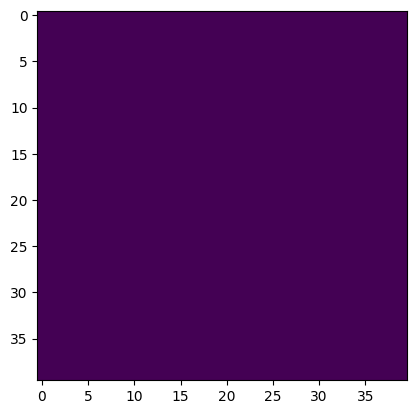

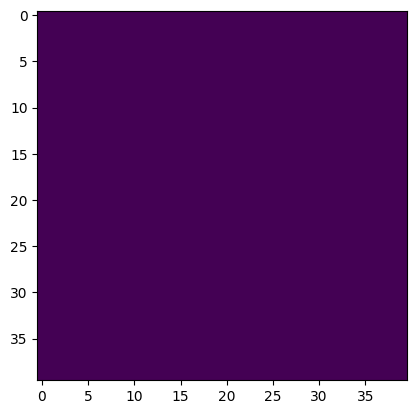

[[ 0  0  0]
 [80 80  6]]


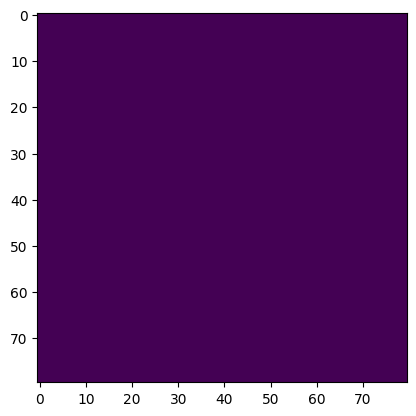

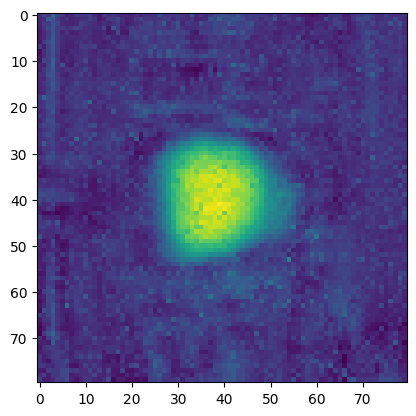

[[  0   0   0]
 [160 160  12]]


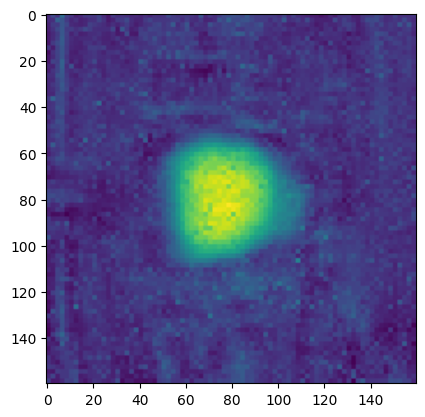

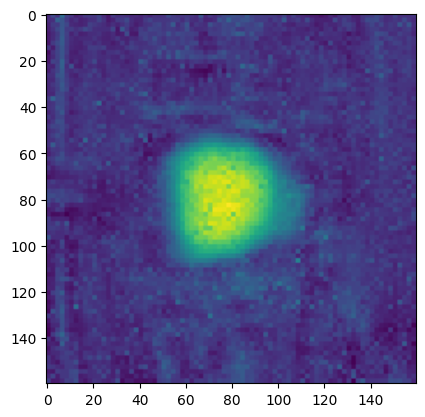

upscaled before cutting


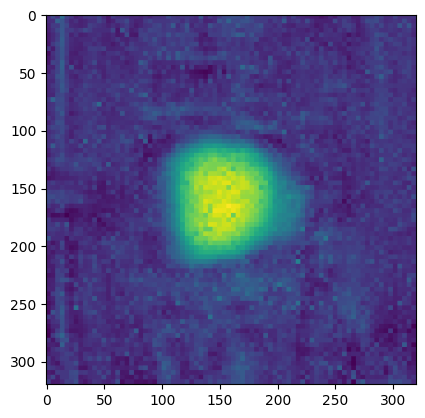

choose from 11 to 91
choose from 103 to 183
choose from 0 to 24
[[  0   0   0]
 [320 320  24]]


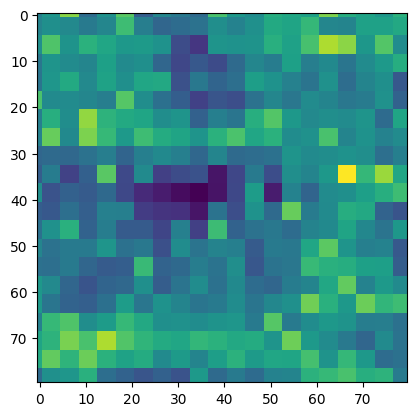

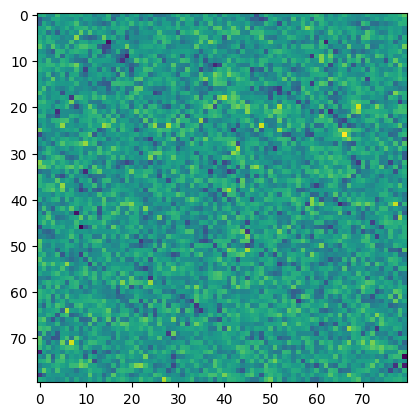

  0%|          | 0/7 [00:01<?, ?it/s]


RuntimeError: aten::view is not yet supported with named tensors. Please drop names via `tensor = tensor.rename(None)`, call the op with an unnamed tensor, and set names on the result of the operation.

In [6]:
#study.eval_experiments()
torch. set_grad_enabled(False)
study.run_experiments()